In [14]:
import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, learning_curve
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV


In [2]:
data = pd.read_csv('dataset/The_final_dataset.csv')
data

,S.No.,Cocoon weight(g),Cocoon length(cm),Width(a)(cm),Width(b)(cm),Width Mean(cm),Cross Sectional Area(cm2),Volume(cm3),Shell weight(g)
0,1,9.35,5.01,3.00,3.01,3.005,13.113595,24.7,1.45
1,2,2.87,5.00,3.01,3.01,3.010,13.102078,25.3,1.17
2,3,8.44,5.02,3.02,3.00,3.010,13.162278,25.8,1.33
3,4,12.87,5.16,2.90,3.15,3.025,13.641616,31.4,1.77
4,5,11.28,5.00,3.05,3.20,3.125,13.525391,29.0,1.44
...,...,...,...,...,...,...,...,...,...
98,99,11.00,4.93,2.92,2.95,2.935,12.617492,26.1,1.40
99,100,7.55,4.90,2.80,2.84,2.820,12.108234,24.3,1.34
100,101,6.27,4.65,2.80,2.75,2.775,11.248116,22.2,1.87
101,102,8.76,4.62,2.88,2.75,2.815,11.301592,23.3,1.50


In [19]:
X = data[['Cocoon length(cm)', 'Width Mean(cm)']].values
y = data['Volume(cm3)'].values

In [16]:
alpha_values = np.logspace(-3, 0, 100)
model_lasso = Lasso()
param_grid = {'alpha':alpha_values}
mse_scoring = make_scorer(mean_squared_error, greater_is_better = False)
r2_scoring = make_scorer(r2_score, greater_is_better = True)
scorers = {
    'mse': mse_scoring,
    'r2': r2_scoring
}
grid_search = GridSearchCV(estimator = model_lasso, param_grid=param_grid, cv=5, scoring=scorers, refit='r2', n_jobs=-1, verbose=2)

In [20]:
grid_search.fit(X, y)
best_alpha = grid_search.best_params_
print(f'Best alpha value: {best_alpha}')
best_lasso_model = grid_search.best_estimator_


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best alpha value: {'alpha': 0.012328467394420659}


In [21]:

k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=1)

# Lists to store the scores for each fold
training_errors = []
validation_errors = []
training_r2 = []
validation_r2 = []

# Perform K-Fold Cross-Validation
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    # Train the model
    best_lasso_model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = best_lasso_model.predict(X_train)
    y_val_pred = best_lasso_model.predict(X_val)
    
    # Calculate and store the errors
    train_error = mean_squared_error(y_train, y_train_pred)
    val_error = mean_squared_error(y_val, y_val_pred)
    
    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    
    training_errors.append(train_error)
    validation_errors.append(val_error)
    
    training_r2.append(train_r2)
    validation_r2.append(val_r2)

# Calculate average errors
avg_train_error = np.mean(training_errors)
avg_val_error = np.mean(validation_errors)

avg_train_r2 = np.mean(training_r2)
avg_val_r2 = np.mean(validation_r2)

print(f'Average Training Error: {avg_train_error}')
print(f'Average Validation Error: {avg_val_error}')


print(f'Average Training Error: {avg_train_r2}')
print(f'Average Validation Error: {avg_val_r2}')



Average Training Error: 4.221756997471216
Average Validation Error: 4.946670183843585
Average Training Error: 0.8275474125402968
Average Validation Error: 0.7887777885304511


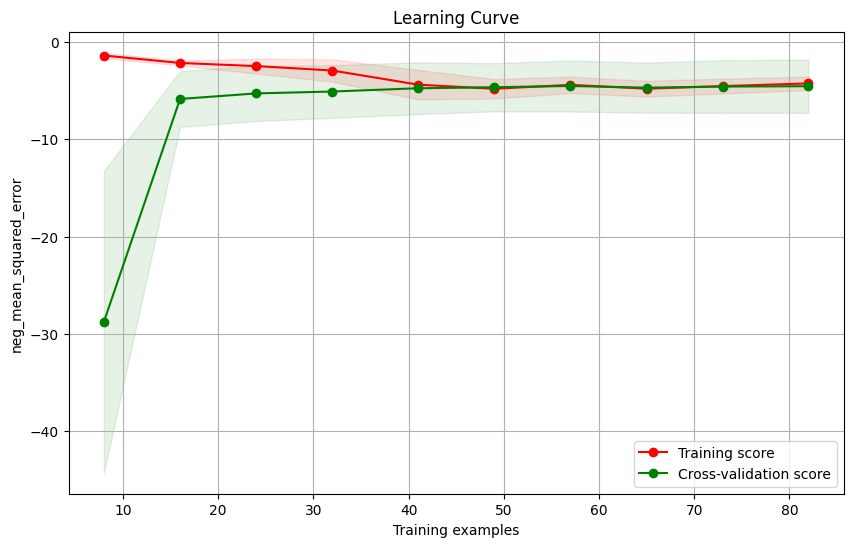

In [22]:
def plot_learning_curve(estimator, X, y, cv, scoring, n_jobs):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=np.linspace(0.1, 1.0, 10))
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.xlabel("Training examples")
    plt.ylabel("neg_mean_squared_error")
    plt.title("Learning Curve")
    plt.legend(loc="best")
    plt.show()

# Plotting the learning curve for Lasso regression
plot_learning_curve(best_lasso_model, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)



In [23]:
joblib.dump(best_lasso_model, "Volume_predictor_1.joblib")

['Volume_predictor_1.joblib']

In [3]:

X1 = data[['Cocoon length(cm)', 'Width Mean(cm)']].values
y1 = data['Volume(cm3)'].values

# Define the model
model_LR = LinearRegression()

# Define the number of folds
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=1)

# Lists to store the scores for each fold
training_errors = []
validation_errors = []
training_r2 = []
validation_r2 = []

# Perform K-Fold Cross-Validation
for train_index, val_index in kf.split(X1):
    X_train, X_val = X1[train_index], X1[val_index]
    y_train, y_val = y1[train_index], y1[val_index]
    
    # Train the model
    model_LR.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = model_LR.predict(X_train)
    y_val_pred = model_LR.predict(X_val)
    
    # Calculate and store the errors
    train_error = mean_squared_error(y_train, y_train_pred)
    val_error = mean_squared_error(y_val, y_val_pred)
    
    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    
    training_errors.append(train_error)
    validation_errors.append(val_error)
    
    training_r2.append(train_r2)
    validation_r2.append(val_r2)

# Calculate average errors
avg_train_error = np.mean(training_errors)
avg_val_error = np.mean(validation_errors)

avg_train_r2 = np.mean(training_r2)
avg_val_r2 = np.mean(validation_r2)

print(f'Average Training Error: {avg_train_error}')
print(f'Average Validation Error: {avg_val_error}')


print(f'Average Training Error: {avg_train_r2}')
print(f'Average Validation Error: {avg_val_r2}')



Average Training Error: 4.264521976145572
Average Validation Error: 4.716973170741221
Average Training Error: 0.8260413706681895
Average Validation Error: 0.7850699475748601
